In [2]:
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
pd.set_option('display.max_columns', None)
import time
import warnings
warnings.filterwarnings("ignore")

import torch
random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
dataset_name = 'compas'

In [4]:
# LOAD Dataset
from exp.data_loader import load_tabular_data

X_train, X_test, Y_train, Y_test, df = load_tabular_data(dataset_name)
columns = list(X_train.columns)
X_train = X_train.values
X_test = X_test.values

XGB
train acc: 0.9874392220421394
test acc: 0.9530364372469635
RF
train acc: 1.0
test acc: 0.9489878542510122
SVC
train acc: 0.9325364667747164
test acc: 0.934412955465587


2022-10-27 11:56:48.764280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


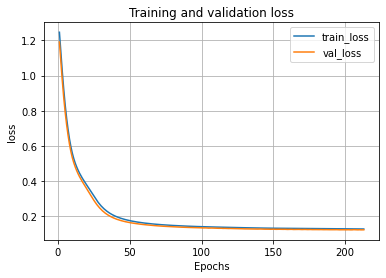

155/155 [==============================] - 0s 917us/step
0.940032414910859
39/39 [==============================] - 0s 970us/step
0.9425101214574899


In [5]:
# load Black Boxes

# XGB
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(n_estimators=60, reg_lambda=3, use_label_encoder=False, eval_metric='logloss')
clf_xgb.fit(X_train, Y_train)
clf_xgb.save_model(f'./blackboxes/{dataset_name}_xgboost')
clf_xgb.load_model(f'./blackboxes/{dataset_name}_xgboost')
y_train_pred = clf_xgb.predict(X_train)
y_test_pred = clf_xgb.predict(X_test)
print('XGB')
print('train acc:',np.mean(np.round(y_train_pred)==Y_train))
print('test acc:',np.mean(np.round(y_test_pred)==Y_test))

#RF
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(random_state=random_seed)
clf_rf.fit(X_train, Y_train)
pickle.dump(clf_rf,open(f'./blackboxes/{dataset_name}_rf.p','wb'))
clf_rf = pickle.load(open(f'./blackboxes/{dataset_name}_rf.p','rb'))
y_train_pred = clf_rf.predict(X_train)
y_test_pred = clf_rf.predict(X_test)
print('RF')
print('train acc:',np.mean(np.round(y_train_pred)==Y_train))
print('test acc:',np.mean(np.round(y_test_pred)==Y_test))

#SVC
from sklearn.svm import SVC
clf_svc = SVC(gamma='auto', probability=True)
clf_svc.fit(X_train, Y_train)
pickle.dump(clf_svc,open(f'./blackboxes/{dataset_name}_svc.p','wb'))
clf_svc = pickle.load(open(f'./blackboxes/{dataset_name}_svc.p','rb'))
y_train_pred = clf_svc.predict(X_train)
y_test_pred = clf_svc.predict(X_test)
print('SVC')
print('train acc:',np.mean(np.round(y_train_pred)==Y_train))
print('test acc:',np.mean(np.round(y_test_pred)==Y_test))

#NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
BATCH_SIZE = 1024
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(2048).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(BATCH_SIZE)
clf_nn = keras.Sequential([
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=5, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])
early_stopping = EarlyStopping(patience=5)
clf_nn.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = clf_nn.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=500,
    callbacks=[early_stopping],
    verbose=0
)
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.grid()
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history, 'loss')
clf_nn.save_weights(f'./blackboxes/{dataset_name}_tf_nn')
from sklearn.metrics import accuracy_score
clf_nn.load_weights(f'./blackboxes/{dataset_name}_tf_nn')
clf_nn.trainable = False
print(accuracy_score(np.round(clf_nn.predict(X_train)),Y_train))
print(accuracy_score(np.round(clf_nn.predict(X_test)),Y_test))

In [6]:
# Print XGBoost and DT trees
# original_feature_names = clf_xgb.get_booster().feature_names
# clf_xgb.get_booster().feature_names = columns
# import xgboost
# fig, ax = plt.subplots(figsize=(30, 30))
# xgboost.plot_tree(clf_xgb, num_trees=4, ax=ax)
# plt.show()
# fig, ax = plt.subplots(figsize=(30, 10))
# xgboost.plot_importance(clf_xgb,ax=ax)
# clf_xgb.get_booster().feature_names = original_feature_names
# from sklearn import tree
# clf_dt = tree.DecisionTreeClassifier()
# clf_dt = clf_dt.fit(X_train, Y_train)
# plt.figure(figsize=(30,10))
# tree.plot_tree(clf_dt,max_depth=3,feature_names=columns,filled=True)
# clf_dt.score(X_test,Y_test)

In [10]:
black_box = 'xgb'

if black_box=='xgb':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_xgb.predict_proba(x)[:,1].ravel()
        else: return clf_xgb.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='rf':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_rf.predict_proba(x)[:,1].ravel()
        else: return clf_rf.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='svc':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_svc.predict_proba(x)[:,1].ravel()
        else: return clf_svc.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='nn':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_nn.predict(x).ravel()
        else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)

In [11]:
X_train = np.hstack((X_train,y_train_pred.reshape(-1,1)))
X_test = np.hstack((X_test,y_test_pred.reshape(-1,1)))

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Latent Space

latent_dim = 10
batch_size = 1024
sigma = 1
max_epochs = 1000
early_stopping = 3
learning_rate = 1e-3

if dataset_name == 'adult':
    idx_cat = [2,3,4,5,6]
elif dataset_name == 'fico':
    idx_cat = None
elif dataset_name == 'german':
    idx_cat = np.arange(3,71,1).tolist()
elif dataset_name == 'compas':
    idx_cat = list(range(13,33,1))

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')

def compute_similarity_Z(Z, sigma):
    D = 1 - F.cosine_similarity(Z[:, None, :], Z[None, :, :], dim=-1)
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def compute_similarity_X(X, sigma, idx_cat=None):
    D_class = torch.cdist(X[:,-1].reshape(-1,1),X[:,-1].reshape(-1,1))
    X = X[:, :-1]
    if idx_cat:
        X_cat = X[:, idx_cat]
        X_cont = X[:, np.delete(range(X.shape[1]),idx_cat)]
        h = X_cat.shape[1]
        m = X.shape[1]
        D_cont = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1)
        D_cat = torch.cdist(X_cat, X_cat, p=0)/h
        D = h/m * D_cat + ((m-h)/m) * D_cont + D_class
    else:
        D_features = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1) 
        D = D_features + D_class
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def loss_function(X, Z, idx_cat, sigma=1):
    Sx = compute_similarity_X(X, sigma, idx_cat)
    Sz = compute_similarity_Z(Z, sigma)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z

# Create Model
model = LinearModel(X_train.shape[1], latent_dim=latent_dim)

In [13]:
train_dataset = TensorDataset(torch.tensor(X_train).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
            postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []

    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  #
        loss  = loss_function(X_batch, Z_batch, idx_cat, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------

    # set model as testing mode
    model.eval()
    batch_loss = []

    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, idx_cat, sigma)
            batch_loss.append(loss.item())

    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch

    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent_{dataset_name}.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent_{dataset_name}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/{dataset_name}_latent_{black_box}_{latent_dim}.pt')

Epoch: 000 Train Sim Loss 0.00000 Test Sim Loss 0.00000 Early Stopping 0

In [14]:
model.load_state_dict(torch.load(f'./models/{dataset_name}_latent_{black_box}_{latent_dim}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

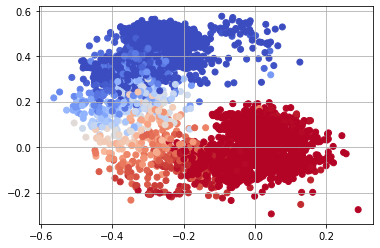

In [ ]:
plt.scatter(Z_train[:,0], Z_train[:,1], c=y_train_pred, cmap='coolwarm')
plt.grid()

# Rules

0.9910931174089069

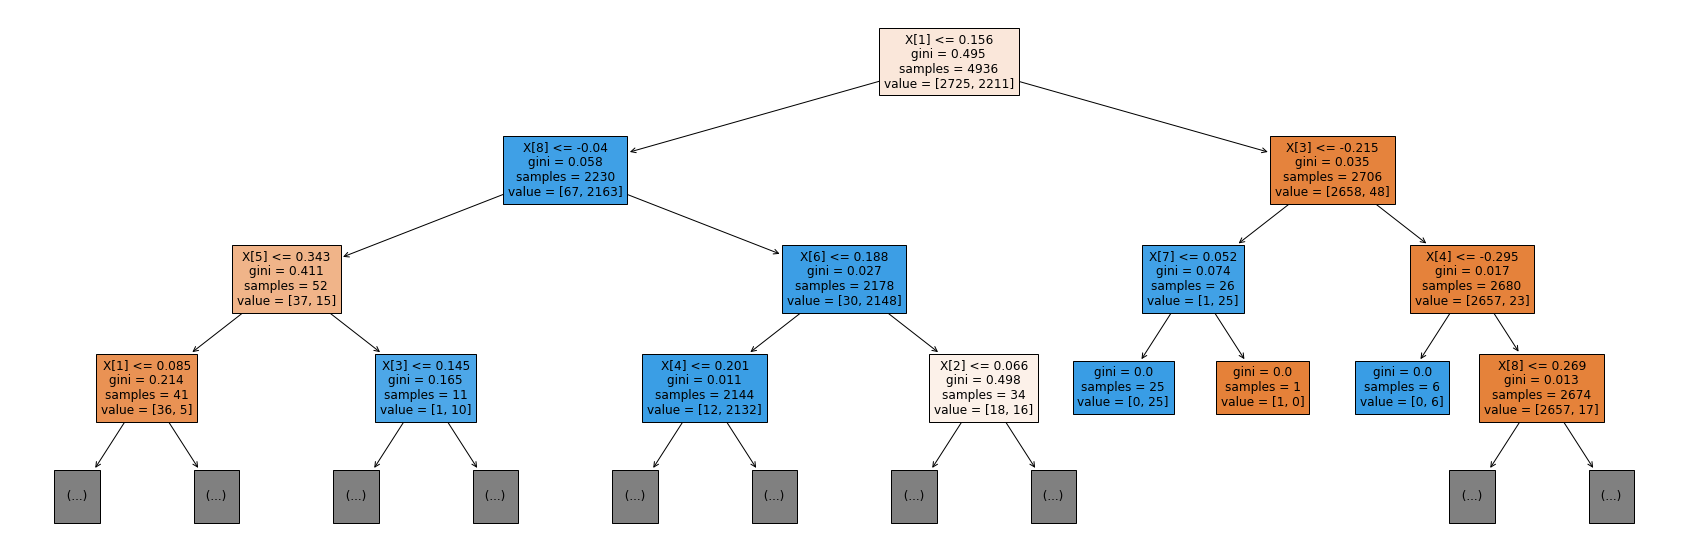

In [47]:
from sklearn import tree
clf_dt = tree.DecisionTreeClassifier()
y_train_pred = clf_xgb.predict(X_train[:,:-1])
y_test_pred = clf_xgb.predict(X_test[:,:-1])
clf_dt = clf_dt.fit(Z_train, y_train_pred)
plt.figure(figsize=(30,10))
tree.plot_tree(clf_dt,max_depth=3,filled=True)
clf_dt.score(Z_test,y_test_pred)

0.9619433198380567

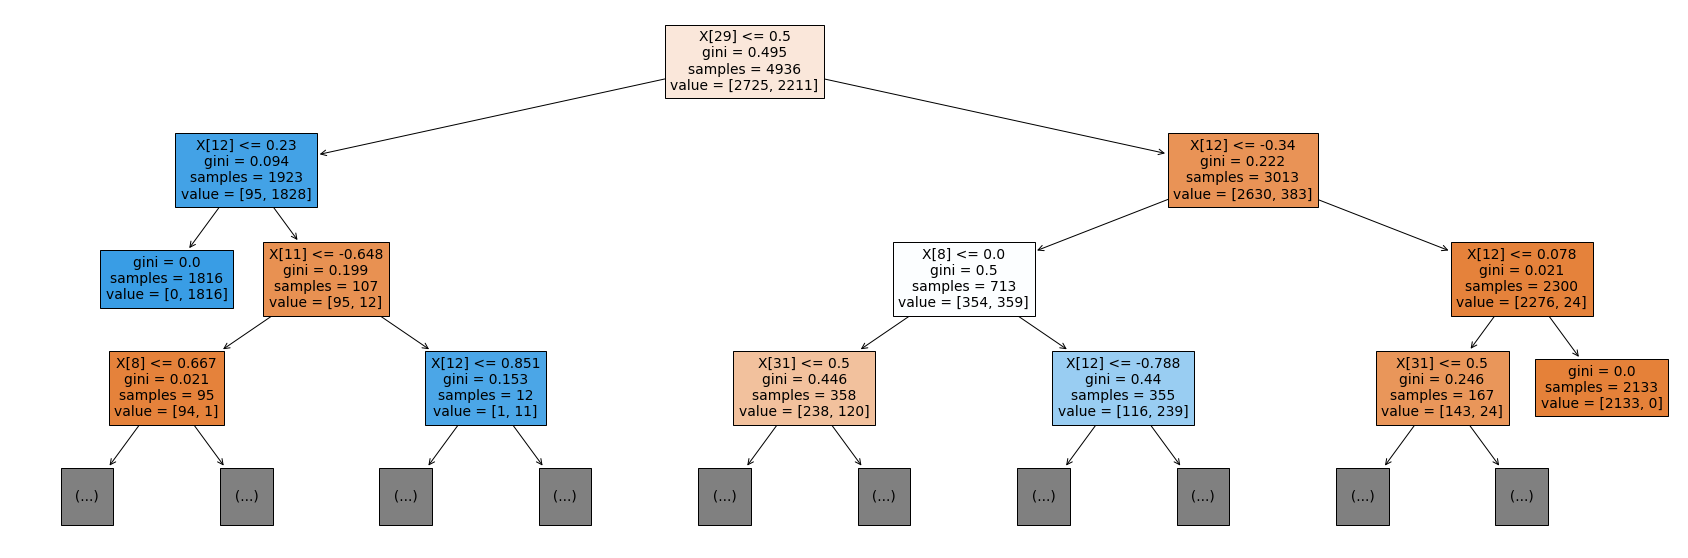

In [52]:
from sklearn import tree
clf_dt = tree.DecisionTreeClassifier()
y_train_pred = clf_xgb.predict(X_train[:,:-1])
y_test_pred = clf_xgb.predict(X_test[:,:-1])
clf_dt = clf_dt.fit(X_train[:,:-1], y_train_pred)
plt.figure(figsize=(30,10))
tree.plot_tree(clf_dt,max_depth=3,filled=True)
clf_dt.score(X_test[:,:-1],y_test_pred)

# Prototypes

In [ ]:
from sklearn.cluster import SpectralClustering, KMeans

Z_train_0 = Z_train[y_train_pred==0]
Z_train_1 = Z_train[y_train_pred==1]

# number of clusters 
n = 10

# n//(1/0.7) adjust for proportion of data
clustering_0 = SpectralClustering(n_clusters=int(n//(1/(y_train_bb==0/len(y_train_bb)))),assign_labels='discretize').fit(Z_train_0)
clustering_1 = SpectralClustering(n_clusters=int(n-n//(1/(y_train_bb==0/len(y_train_bb)))),assign_labels='discretize').fit(Z_train_1)

centers = []
for i in range(int(n//(1/(y_train_bb==0/len(y_train_bb))))):
    centers.append(np.mean(Z_train_0[clustering_0.labels_==i],axis=0))
for i in range(int(n-n//(1/(y_train_bb==0/len(y_train_bb))))):
    centers.append(np.mean(Z_train_1[clustering_1.labels_==i],axis=0))
centers = np.stack(centers)

from scipy.spatial.distance import cdist
idx = np.argmin(cdist(centers,Z_train),axis=1)
proto_latent_clustering = pd.DataFrame(X_train_latent[idx,:-1],columns=X_train.columns)

proto_pred = predict(proto_latent_clustering)
print('perc positive proto: ', np.mean(proto_pred))

from scipy.spatial.distance import cdist
knn_1 = np.argmin(cdist(proto_latent_clustering.values, X_test_latent[:,:-1]),axis=0)
d = {}
for i in range(n):
    d[i]=proto_pred[i]
knn_1 = [d[x] for x in knn_1]
print('accuracy 1-KNN:',accuracy_score(knn_1,y_test_bb))

print('avg_distance:',np.mean(cdist(proto_latent_clustering.values,proto_latent_clustering.values)))

# Counterfactuals

In [16]:
w = model.fc1.weight.detach().numpy()
b = model.fc1.bias.detach().numpy()
y_contrib = model.fc1.weight.detach().numpy()[:,-1]

In [17]:
def compute_cf(q, indexes):
    q_pred = predict(q[:-1].reshape(1,-1),return_proba=True)
    q_cf = q.copy()
    q_cf_preds = []
    q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
    if q_pred > 0.5:
        m = -0.1
    else:
        m = +0.1
    while np.round(q_pred) == np.round(q_cf_preds[-1]):
        v = np.array(model(torch.tensor(q_cf).float()).detach().numpy()+m*y_contrib)
        c_l = [v[l] - np.sum(q_cf*w[l,:]) - b[l] for l in range(latent_dim)]
        M = []
        for l in range(latent_dim):
            M.append([np.sum(w[k,indexes]*w[l,indexes]) for k in range(latent_dim)])
        M = np.vstack(M)
        lambda_k = np.linalg.solve(M, c_l)
        delta_i = [np.sum(lambda_k*w[:,i]) for i in indexes]
        q_cf[indexes] += delta_i
        #q_cf = np.clip(q_cf,-1,1)
        if float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)) in q_cf_preds:
            return q_cf
        q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
        q_cf[-1] = q_cf_preds[-1]
    return q_cf

In [18]:
from itertools import combinations
from scipy.spatial.distance import cdist

d_dist = []
d_impl = []
d_count = []
d_adv = []
num = []
div_dist = []
div_count = []
n = [0]

for idx in tqdm(range(n)):
    q = X_test[idx,:].copy()
    q_pred = predict(q[:-1].reshape(1,-1),return_proba=False)
    q_cfs = []
    l_i = []
    l_f = []

    for indexes in list(combinations(list(range(X_train.shape[1]-1)),1)):    
        q_cf = compute_cf(q, list(indexes))
        q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
        if q_pred:
            if q_cf_pred<0.5:
                q_cfs.append(q_cf)
        else:
            if q_cf_pred>0.5:
                q_cfs.append(q_cf) 

    for indexes in list(combinations(list(range(X_train.shape[1]-1)),2)):    
        q_cf = compute_cf(q, list(indexes))
        q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
        if q_pred:
            if q_cf_pred<0.5:
                q_cfs.append(q_cf)
        else:
            if q_cf_pred>0.5:
                q_cfs.append(q_cf) 
        l_i.append([list(indexes),q_cf_pred])
    r = np.argsort(np.stack(np.array(l_i,dtype=object)[:,1]).ravel())[-10:]
    l_i = np.array(l_i,dtype=object)[r,0]

    while len(l_i[0])<6:
        for e in l_i:
            for i in list(np.delete(range(X_train.shape[1]-1),e)):
                q_cf = compute_cf(q, e+[i])
                q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
                if q_pred:
                    if q_cf_pred<0.5:
                        q_cfs.append(q_cf)
                else:
                    if q_cf_pred>0.5:
                        q_cfs.append(q_cf) 
                l_f.append([e+[i],q_cf_pred])
        r = np.argsort(np.stack(np.array(l_f,dtype=object)[:,1]).ravel())[-10:]
        l_f = np.array(l_f,dtype=object)[r,0]
        l_i = l_f.copy()
        l_f = []
    
    if len(q_cfs)<1:
        continue
    else:
        q_cfs = np.vstack(q_cfs)